# Period 1 -  Standard analyses for RNA seq data (unsupervised)


# Abstract

This workshop summarizes the main approaches to analyzing sequencing data to obtain per-gene count data, but does not go through how to do it explicitly. It demonstrates approaches to reading, annotating, and summarizing count data using [tximport](http://bioconductor.org/packages/) and various Bioconductor annotation resources, followed by unsupervised exploratory data analysis.

This workshop uses quotes and materials from [RNA-seq workflow: gene-level exploratory analysis and differential expression](https://www.bioconductor.org/help/workflows/rnaseqGene/) by Love, Anders, Kim, and Huber.

#  Approaches to processing raw data: alignment vs. alignment-free methods

The computational analysis of an RNA-seq experiment begins from the FASTQ files that contain the nucleotide sequence of each read and a quality score at each position. These reads are either **aligned** to a reference genome or transcriptome, or the abundances and estimated counts per transcript can be estimated **without alignment**. For a paired-end experiment, the software will require both FASTQ files. The output of this alignment step is commonly stored in a file format called SAM/BAM.

RNA-seq aligners differ from DNA aligners in their ability to recognize intron-sized gaps that are spliced from transcripts, and their objective of counting transcripts. [Baruzzo et al. 2017](https://www.nature.com/articles/nmeth.4106) provide a useful summary of software for aligning RNA-seq reads to a reference genome, and benchmark these using synthetic data for base-level and splice junction precision and recall, sensitivity to tuning parameters, and runtime performance. Some popular alignment-based tools include STAR, TopHat2, Subread, and Novoalign. *de novo* alignment does not use a reference genome: while it offers the possibility of discovering novel transcripts in rearranged genomes and genomes without good references, it requires more resources and manual effort and is less accurate for known transcripts, so for most people working with model organisms it is probably not a good option. 

Alignment-free tools have gained popularity for their fast performance and low memory requirements while maintaining good accuracy.  Instead of directly aligning RNA-seq reads to a reference genome, they perform "pseudo-alignment" by assigning reads to transcripts that contain compatible k-mers. The most popular of these tools are [Salmon](https://combine-lab.github.io) and [Kallisto](https://pachterlab.github.io/kallisto/). These generate a table of read counts directly without the need for a SAM/BAM file as a starting or intermediate step. 

You can easily perform RNA-seq alignment in R using [Rsubread](http://bioconductor.org/packages/Rsubread) and [GenomicAlignments](http://bioconductor.org/packages/GenomicAlignments), but the rest of this workshop assumes you are starting with the output some sequence analysis pipeline.

Personally, I would recommend using pseudo-alignment by Salmon [according to this tutorial](https://combine-lab.github.io/salmon/getting_started/) to process raw reads to TPM. 
It is a very fast, accurate, well-tested, and well-documented command-line tool. It is
especially Bioconductor-friendly, because the 
[tximport vignette](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html) 
includes steps to import Salmon results as a *DESeqDataSet* object for use in the [DESeq2](http://bioconductor.org/packages/DESeq2) package.

#  Annotating and importing expression counts

## Measures of transcript abundance

The differential expression analyses introduced here assume you are analyzing a count table of Transcripts Per Million (TPM) or Counts Per Million (CPM) by samples. Note that while TPM and CPM would order the abundance of different transcripts very differently, for differential expression these differences are not as important. You should **not** use Fragments Per Kilobase per Million reads (FPKM) or otherwise normalize by library size / read depth. The negative binomial log-linear statistical model used by [DESeq2](http://bioconductor.org/packages/DESeq2) and [edgeR](http://bioconductor.org/packages/) are intended for use on count data, and achieve better performance than can be achieved with read depth-normalized data. 

## Importing with tximport

The [tximport vignette](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html) demonstrates 
the import of quantification files generated by the Salmon software, but also provides example data and methods of import for other popular RNA-seq quantification software:

In [1]:
library(tximportData)
datadir <- system.file("extdata", package = "tximportData")
list.files(datadir)

[1] "cufflinks"            "kallisto"             "kallisto_boot"       
 [4] "rsem"                 "sailfish"             "salmon"              
 [7] "salmon_gibbs"         "samples_extended.txt" "samples.txt"         
[10] "tx2gene.csv"

Next, we create a named vector pointing to the quantification
files. We will create a vector of filenames first by reading in a
table that contains the sample IDs, and then combining this with `dir`
and `"quant.sf"`.

In [2]:
samples <- read.table(file.path(datadir, "samples.txt"), header=TRUE)
samples

pop,center,assay,sample,experiment,run
TSI,UNIGE,NA20503.1.M_111124_5,ERS185497,ERX163094,ERR188297
TSI,UNIGE,NA20504.1.M_111124_7,ERS185242,ERX162972,ERR188088
TSI,UNIGE,NA20505.1.M_111124_6,ERS185048,ERX163009,ERR188329
TSI,UNIGE,NA20507.1.M_111124_7,ERS185412,ERX163158,ERR188288
TSI,UNIGE,NA20508.1.M_111124_2,ERS185362,ERX163159,ERR188021
TSI,UNIGE,NA20514.1.M_111124_4,ERS185217,ERX163062,ERR188356


In [3]:
files <- file.path(datadir, "salmon", samples$run, "quant.sf")
names(files) <- paste0("sample",1:6)
all(file.exists(files))

[1] TRUE

The *tximport* package has a single function for importing
transcript-level estimates.  The `type` argument is used to specify
what software was used for estimation ("kallisto", "salmon",
"sailfish", and "rsem" are implemented).  A simple list with
matrices, "abundance", "counts", and "length", is returned, where the
transcript level information is summarized to the gene-level.  The
"length" matrix can be used to generate an offset matrix for
downstream gene-level differential analysis of count matrices, as
shown below.

**Note**: While *tximport* works without any dependencies, it is
significantly faster to read in files using the *readr* package.  If
*tximport* detects that *readr* is installed, then it will use the
`readr::read_tsv` function by default. A change from version 1.2 to
1.4 is that the reader is not specified by the user anymore, but
chosen automatically based on the availability of the *readr*
package. Advanced users can still customize the import of files using
the `importer` argument.

The following imports transcript-level counts *without* summarizing to gene level:

In [4]:
library(tximport)
library(readr)
txi <- tximport(files, type="salmon", txOut=TRUE)
##txi <- tximport(files, type="salmon", tx2gene=tx2gene)
names(txi)
head(txi$counts)

reading in files with read_tsv
1 2 3 4 5 6 


[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

,sample1,sample2,sample3,sample4,sample5,sample6
NR_001526,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
NR_001526_1,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
NR_001526_2,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
NM_130786,1.09232e+02,3.16224e+02,1.10638e+02,1.16000e+02,8.63843e+01,7.69163e+01
NR_015380,8.39697e+01,1.38449e+02,1.19274e+02,1.51083e+02,1.23985e+02,1.03251e+02
NM_001198818,1.88414e-04,3.16805e-05,4.28546e-05,1.60980e-06,3.71142e-04,3.10031e-08


## Annotating transcripts to genes and summarizing

If your (pseudo-) alignment software provides a map between transcripts and genes, you can specify that map in `tximport` to summarize  counts at the gene level in the same step (see the `tx2gene` argument of `?tximport::tximport`). For this example, such a map is included in the `tximportData` package and is available by doing:

In [5]:
tx2gene <- read.csv(file.path(datadir, "tx2gene.csv"))

"In real life" you have a number of options, using either built-in Bioconductor annotations resources or other sources of annotations. Below is the option given in the `tximportData` package; three more are given in the [Appendix](#appendix).

If you have used an *Ensembl* transcriptome for (pseudo-)alignment, you can use one of the
[ensembldb](http://bioconductor.org/packages/ensembldb) packages to create the transcript to gene map. 

You *can* use the following shortcut method with `ensembldb` packages:

In [6]:
suppressPackageStartupMessages(library(EnsDb.Hsapiens.v86))
## the different units you could summarize by:
listColumns(EnsDb.Hsapiens.v86)
tx3gene <- transcripts(EnsDb.Hsapiens.v86, columns="symbol", 
                  return.type="DataFrame")
(tx3gene <- tx3gene[, 2:1])

[1] "seq_name"              "seq_length"            "is_circular"          
 [4] "gene_id"               "entrezid"              "exon_id"              
 [7] "exon_seq_start"        "exon_seq_end"          "gene_name"            
[10] "gene_biotype"          "gene_seq_start"        "gene_seq_end"         
[13] "seq_strand"            "seq_coord_system"      "symbol"               
[16] "name"                  "value"                 "tx_id"                
[19] "protein_id"            "protein_sequence"      "protein_domain_id"    
[22] "protein_domain_source" "interpro_accession"    "prot_dom_start"       
[25] "prot_dom_end"          "tx_biotype"            "tx_seq_start"         
[28] "tx_seq_end"            "tx_cds_seq_start"      "tx_cds_seq_end"       
[31] "tx_name"               "exon_idx"              "uniprot_id"           
[34] "uniprot_db"            "uniprot_mapping_type"

DataFrame with 216741 rows and 2 columns
                 tx_id      symbol
           <character> <character>
1      ENST00000000233        ARF5
2      ENST00000000412        M6PR
3      ENST00000000442       ESRRA
4      ENST00000001008       FKBP4
5      ENST00000001146     CYP26B1
...                ...         ...
216737        LRG_96t1      RAB27A
216738        LRG_97t1        RAC2
216739        LRG_98t1        RAG1
216740       LRG_992t1        ESR1
216741        LRG_99t1        RAG2

But there is a more general-purpose method that works both for `EnsDb` databases and for `TxDb` databases:

In [7]:
library(EnsDb.Hsapiens.v86)

In [8]:
keytypes(EnsDb.Hsapiens.v86)

[1] "ENTREZID"        "EXONID"          "GENEBIOTYPE"     "GENEID"         
 [5] "GENENAME"        "PROTEINDOMAINID" "PROTEINID"       "SEQNAME"        
 [9] "SEQSTRAND"       "SYMBOL"          "TXBIOTYPE"       "TXID"           
[13] "TXNAME"          "UNIPROTID"

In [9]:
columns(EnsDb.Hsapiens.v86)

[1] "ENTREZID"            "EXONID"              "EXONIDX"            
 [4] "EXONSEQEND"          "EXONSEQSTART"        "GENEBIOTYPE"        
 [7] "GENEID"              "GENENAME"            "GENESEQEND"         
[10] "GENESEQSTART"        "INTERPROACCESSION"   "ISCIRCULAR"         
[13] "PROTDOMEND"          "PROTDOMSTART"        "PROTEINDOMAINID"    
[16] "PROTEINDOMAINSOURCE" "PROTEINID"           "PROTEINSEQUENCE"    
[19] "SEQCOORDSYSTEM"      "SEQLENGTH"           "SEQNAME"            
[22] "SEQSTRAND"           "SYMBOL"              "TXBIOTYPE"          
[25] "TXCDSSEQEND"         "TXCDSSEQSTART"       "TXID"               
[28] "TXNAME"              "TXSEQEND"            "TXSEQSTART"         
[31] "UNIPROTDB"           "UNIPROTID"           "UNIPROTMAPPINGTYPE"

In [10]:
k <- keys(EnsDb.Hsapiens.v86, "TXNAME")
tx4gene <- select(EnsDb.Hsapiens.v86, keys=k, 
                  keytype = "TXNAME", columns = "SYMBOL")
tx4gene <- tx4gene[, 3:2]

In [11]:
# Check that this method is equivalent to the previous one:
all.equal(tx4gene[, 1], tx3gene[, 1])
all.equal(tx4gene[, 2], tx3gene[, 2])

[1] TRUE

[1] TRUE

So wherever you get your gene models from, you can convert it to a `TxDb` and use the same powerful `select()` commands and other Bioconductor database features.

Finally, however you created your transcript to gene map, you can use it to summarize transcripts to genes:

In [12]:
txi.sum <- summarizeToGene(txi, tx2gene)

transcripts missing from tx2gene: 3
summarizing abundance
summarizing counts
summarizing length


# The SummarizedExperiment object for representing experimental data

**The component parts of a *SummarizedExperiment* object.** 

* `assay(se)` or `assays(se)$count` contains the matrix of counts
* `colData(se)` may contain data about the columns, e.g. patients or biological units
* `rowData(se)` may contain data about the rows, e.g. transcript annotations
* `rowRanges(se)` may contain ranges data for the transcripts
* `exptData(se)` may contain information about the experiment

<img src="https://github.com/waldronlab/BrownCOBRE2018/blob/master/notebooks_day2/SummarizedExperiment.jpg?raw=true", alt="SummarizedExperiment image", style="width:500px">

**Note**: The `rowRanges` for data summarized at the gene level could be a *GRanges* providing ranges of genes, or a *GRangesList* providing ranges of exons grouped by gene.  Both are accessible from TxDb objects, for example the last one created above:

Some exploratory analysis of a demo `RangedSummarizedExperiment`:

In [13]:
suppressPackageStartupMessages({
    library(airway)
    library(SummarizedExperiment)
})

In [14]:
data(airway)

In [15]:
airway

class: RangedSummarizedExperiment 
dim: 64102 8 
metadata(1): ''
assays(1): counts
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

In [16]:
dim(airway)

[1] 64102     8

In [17]:
assayNames(airway)

[1] "counts"

In [18]:
head(assay(airway), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508


In [19]:
colSums(assay(airway))

SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520 
  20637971   18809481   25348649   15163415   24448408   30818215   19126151 
SRR1039521 
  21164133

The `rowRanges` here is a *GRangesList*. The first gene contains 17 exons:

In [20]:
rowRanges(airway)

GRangesList object of length 64102:
$ENSG00000000003 
GRanges object with 17 ranges and 2 metadata columns:
       seqnames               ranges strand |   exon_id       exon_name
          <Rle>            <IRanges>  <Rle> | <integer>     <character>
   [1]        X [99883667, 99884983]      - |    667145 ENSE00001459322
   [2]        X [99885756, 99885863]      - |    667146 ENSE00000868868
   [3]        X [99887482, 99887565]      - |    667147 ENSE00000401072
   [4]        X [99887538, 99887565]      - |    667148 ENSE00001849132
   [5]        X [99888402, 99888536]      - |    667149 ENSE00003554016
   ...      ...                  ...    ... .       ...             ...
  [13]        X [99890555, 99890743]      - |    667156 ENSE00003512331
  [14]        X [99891188, 99891686]      - |    667158 ENSE00001886883
  [15]        X [99891605, 99891803]      - |    667159 ENSE00001855382
  [16]        X [99891790, 99892101]      - |    667160 ENSE00001863395
  [17]        X [99894942, 9

The `rowRanges` also contains metadata about the construction
of the gene model in the `metadata` slot. Here we use a helpful R
function, `str`, to display the metadata compactly:

In [21]:
str(metadata(rowRanges(airway)))

List of 1
 $ genomeInfo:List of 20
  ..$ Db type                                 : chr "TranscriptDb"
  ..$ Supporting package                      : chr "GenomicFeatures"
  ..$ Data source                             : chr "BioMart"
  ..$ Organism                                : chr "Homo sapiens"
  ..$ Resource URL                            : chr "www.biomart.org:80"
  ..$ BioMart database                        : chr "ensembl"
  ..$ BioMart database version                : chr "ENSEMBL GENES 75 (SANGER UK)"
  ..$ BioMart dataset                         : chr "hsapiens_gene_ensembl"
  ..$ BioMart dataset description             : chr "Homo sapiens genes (GRCh37.p13)"
  ..$ BioMart dataset version                 : chr "GRCh37.p13"
  ..$ Full dataset                            : chr "yes"
  ..$ miRBase build ID                        : chr NA
  ..$ transcript_nrow                         : chr "215647"
  ..$ exon_nrow                               : chr "745593"
  ..$ cds_nrow     

The `colData`:

In [22]:
colData(airway)

DataFrame with 8 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN024

## Exercise

Create your own *SummarizedExperiment* and *RangedSummarizedExperiment* objects using the examples in `?SummarizedExperiment`. *SummarizedExperiment* objects can be the starting point for many analyses.

#  Exploratory data analysis

## Standardization / transformation of count data for visual exploration

Features (e.g. genes) are typically "standardized": 
 * because the differences in overall levels between features are often not due to biological effects but technical ones, *e.g.* GC bias, PCR amplification efficiency, ...
 * because we don't want a few very high-variance genes to dominate the distance (a judgement call)

Standardization traditionally meant converting to z-score:

$$x_{gi} \leftarrow \frac{(x_{gi} - \bar{x}_g)}{s_g}$$     

But `DESeq2` and `edgeR` provide their own RNA-seq specific standardization methods.

We will use standardization for the purposes of visualization below, but for statistical testing in the next period, we will go back to the original count data 
as required by the statistical procedures used.

## Exploring the airway dataset

Once we have our fully annotated *SummarizedExperiment* object,
we can construct a *DESeqDataSet* object from it that will then form
the starting point of the analysis.
We add an appropriate design for the analysis (more on model formulae in the next period):

In [23]:
suppressPackageStartupMessages(library(DESeq2))

In [24]:
dds <- DESeqDataSet(airway, design = ~ cell + dex)

## Pre-filtering the dataset

Our count matrix contains many rows with only
zeros, and additionally many rows with only a few fragments total. In
order to reduce the size of the object, and to increase the speed of
our functions, we can remove the rows that have no or nearly no
information about the amount of gene expression.  Here we apply the
most minimal filtering rule: removing rows of the *DESeqDataSet* that
have no counts, or only a single count across all samples. Additional
weighting/filtering to improve power is applied at a later step in the
workflow.

In [25]:
nrow(dds)

[1] 64102

In [26]:
dds <- dds[ rowSums(counts(dds)) > 1, ]
nrow(dds)

[1] 29391

**Note**: For differential expression analysis later, filtering is 
allowable but not necessary if using "Independent Hypothesis Weighting",
as is the default behavior of `DESeq2`.

## The rlog and variance stabilizing transformations

Many common statistical methods for exploratory analysis of
multidimensional data, for example clustering and *principal
components analysis* (PCA), work best for data that generally has the
same range of variance at different ranges of the mean values. When
the expected amount of variance is approximately the same across
different mean values, the data is said to be *homoskedastic*. For
RNA-seq counts, however, the expected variance grows with the mean. For
example, if one performs PCA directly on a matrix of
counts or normalized counts (e.g. correcting for differences in
sequencing depth), the resulting plot typically depends mostly
on the genes with *highest* counts because they show the largest
absolute differences between samples. A simple and often used
strategy to avoid this is to take the logarithm of the normalized
count values plus a pseudocount of 1; however, depending on the
choice of pseudocount, now the genes with the very *lowest* counts
will contribute a great deal of noise to the resulting plot, because
taking the logarithm of small counts actually inflates their variance.
We can quickly show this property of counts with some simulated
data (here, Poisson counts with a range of lambda from 0.1 to 100).
We plot the standard deviation of each row (genes) against the mean:

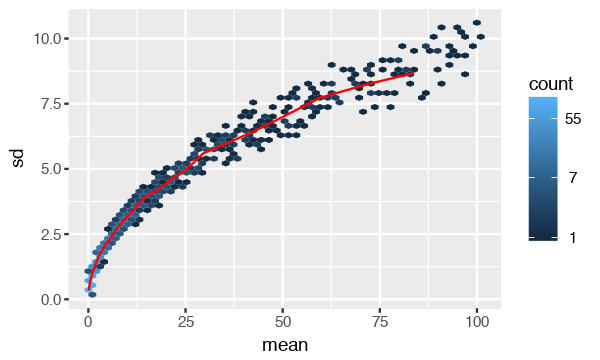

In [27]:
options(repr.plot.height=3, repr.plot.width=5)
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)
library(vsn)
meanSdPlot(cts, ranks = FALSE)

And for logarithm-transformed counts:

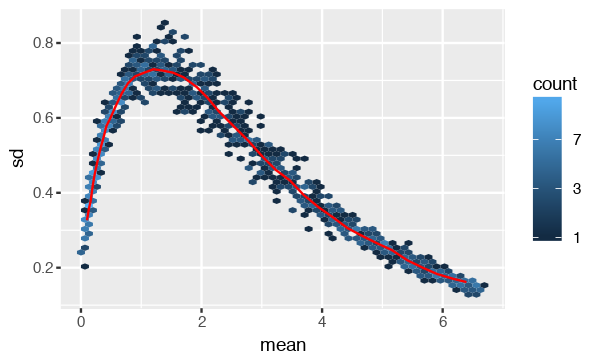

In [28]:
options(repr.plot.height=3, repr.plot.width=5)
log.cts.one <- log2(cts + 1)
meanSdPlot(log.cts.one, ranks = FALSE)

The logarithm with a small pseudocount amplifies differences when the
values are close to 0. The low count genes with low signal-to-noise
ratio will overly contribute to sample-sample distances and PCA
plots. 

As a solution, *DESeq2* offers two transformations for count data that
stabilize the variance across the mean: the 
*regularized-logarithm transformation* or *rlog* ([Love, Huber, Anders, Genome Biology 2014](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8)),
and the *variance stabilizing transformation* (VST)
for negative binomial data with a dispersion-mean trend
([Anders and Huber, Genome Biology 2010](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-10-r106)), implemented in the *vst* function.

For genes with high counts, the rlog and VST will give similar result
to the ordinary log2 transformation of normalized counts.  For genes
with lower counts, however, the values are shrunken towards the genes'
averages across all samples. The rlog-transformed or VST data then
becomes approximately homoskedastic, and can be used directly for
computing distances between samples, making PCA plots, or as input to
downstream methods which perform best with homoskedastic data.

**Which transformation to choose?** The rlog tends to work well on
small datasets (n < 30), sometimes outperforming the VST when there is
a large range of sequencing depth across samples (an order of
magnitude difference). The VST is much faster to compute and is less
sensitive to high count outliers than the rlog. We therefore recommend
the VST for large datasets (hundreds of samples). You can perform both
transformations and compare the `meanSdPlot` or PCA plots generated,
as described below.

Note that the two transformations offered by DESeq2 are provided for
applications *other* than differential testing. 
For differential testing we recommend the
*DESeq* function applied to raw counts, as described later
in this workflow, which also takes into account the dependence of the
variance of counts on the mean value during the dispersion estimation
step.

The function *rlog* returns an object based on the *SummarizedExperiment*
class that contains the rlog-transformed values in its *assay* slot.

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.385683,9.052608,9.516875,9.285338,9.839085,9.530311,9.663255,9.277699
ENSG00000000419,8.869616,9.138271,9.036116,9.075295,8.972126,9.131824,8.861534,9.060905
ENSG00000000457,7.961369,7.881385,7.824079,7.921490,7.751699,7.886441,7.957121,7.912123


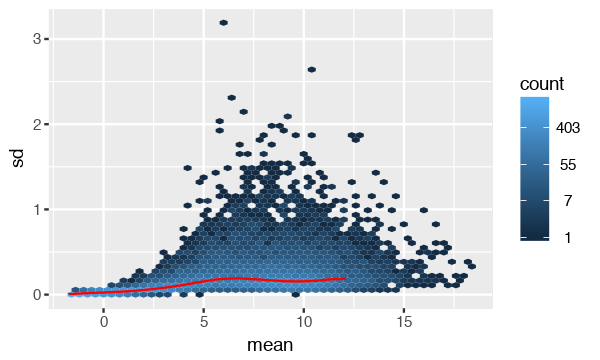

In [29]:
options(repr.plot.height=3, repr.plot.width=5)
rld <- rlog(dds, blind = FALSE)
head(assay(rld), 3)
meanSdPlot(assay(rld), ranks=FALSE)

The function *vst* returns a similar object:

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.742340,9.430742,9.867872,9.646126,10.183344,9.880660,10.010591,9.640065
ENSG00000000419,9.334009,9.582000,9.486456,9.523397,9.427605,9.575154,9.326341,9.509553
ENSG00000000457,8.765748,8.698940,8.651978,8.732908,8.593308,8.703164,8.762419,8.724586


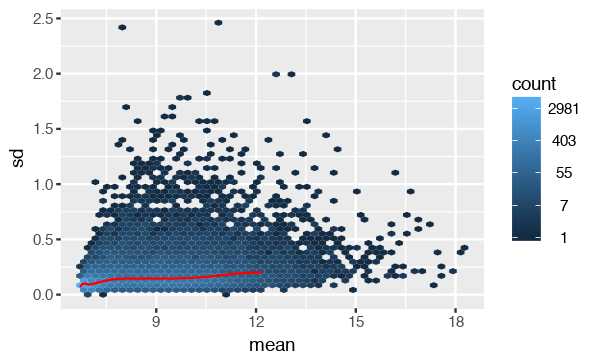

In [30]:
vsd <- vst(dds, blind = FALSE)
head(assay(vsd), 3)
meanSdPlot(assay(vsd), ranks=FALSE)

In the above function calls, we specified `blind = FALSE`, which means
that differences between cell lines and treatment (the variables in
the design) will not contribute to the expected variance-mean trend of
the experiment. The experimental design is not used directly in the
transformation, only in estimating the global amount of variability in
the counts.  For a fully *unsupervised* transformation, one can set
`blind = TRUE` (which is the default).

To show the effect of the transformation, in the figure below
we plot the first sample
against the second, first simply using the *log2* function (after adding
1, to avoid taking the log of zero), and then using the rlog- and VST-transformed
values. For the *log2* approach, we need to first estimate *size factors* to
account for sequencing depth, and then specify `normalized=TRUE`.
Sequencing depth correction is done automatically for the *rlog*
and the *vst*.

In [31]:
dds <- estimateSizeFactors(dds)

In [32]:
ddsESF <- estimateSizeFactors(dds)
df1 <- data.frame(log2(counts(ddsESF, normalized=TRUE)[, 1:2] + 1))
df1$transformation <- "log2(x + 1)"
df2 <- data.frame(assay(rld)[, 1:2])
df2$transformation <- "rld"
df3 <- data.frame(assay(vsd)[, 1:2])
df3$transformation <- "vsd"
df <- rbind(df1, df2, df3)
colnames(df)[1:2] <- c("x", "y")
head(df)

,x,y,transformation
ENSG00000000003,9.375722,8.968399,log2(x + 1)
ENSG00000000419,8.836718,9.169098,log2(x + 1)
ENSG00000000457,7.994317,7.885375,log2(x + 1)
ENSG00000000460,5.897577,5.962838,log2(x + 1)
ENSG00000000938,0.000000,0.000000,log2(x + 1)
ENSG00000000971,11.633403,12.003610,log2(x + 1)


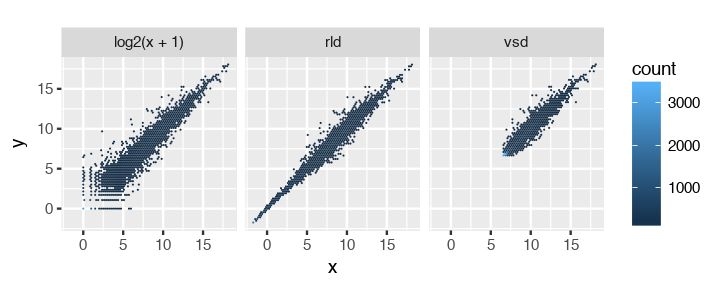

In [33]:
options(repr.plot.width=6, repr.plot.height=2.5)
library(ggplot2)
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

**Scatterplot of transformed counts from two samples**. Shown are
scatterplots using the log2 transform of normalized counts (left),
using the rlog (middle), and using the VST (right). While the rlog is
on roughly the same scale as the log2 counts, the VST has a upward
shift for the smaller values. It is the differences between samples
(deviation from y=x in these scatterplots) which will contribute to
the distance calculations and the PCA plot.

We can see how genes with low counts (bottom left-hand corner) seem to
be excessively variable on the ordinary logarithmic scale, while the
rlog transform and VST compress differences for the low count genes
for which the data provide little information about differential
expression.

## Boxplots of transformed distributions

Boxplots of the count distributions in each sample are a good way to understand the effects these transformations have.

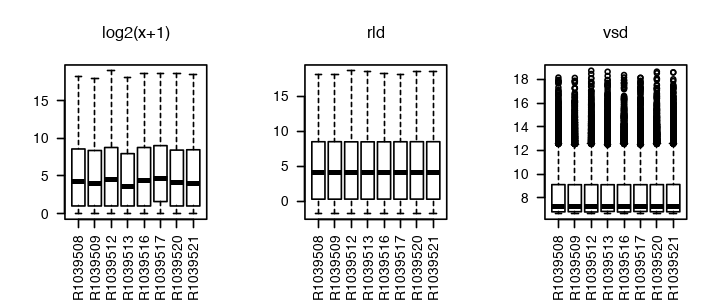

In [34]:
par(mfrow=c(1,3))
boxplot(log2(assay(ddsESF)+1), las=2, main="log2(x+1)")
boxplot(assay(rld), las=2, main="rld")
boxplot(assay(vsd), las=2, main="vsd")

# Sample distances

## The importance of distances

High-dimensional data are complex and impossible to visualize in raw form. They represent
thousands of dimensions, but we can only visualize 2-3.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/c/ca/Animals_png_set_by_mossi889-d4uye4q.png" alt="animals" align="middle" style="height: 350px;">
</center>
**Animals**: Distances can simplify thousands of dimensions or measurements, but encompass assumptions about what kinds of differences are important.

All clustering and classification of samples and/or genes involves
combining or identifying objects that are close or similar. Distances 
or similarities are mathematical representations of what we mean by 
close or similar. The choice of distance is important, and 
is subject-matter specific.

See: http://master.bioconductor.org/help/course-materials/2002/Summer02Course/Distance/distance.pdf

## Distances for exploratory RNA-seq data analysis

A useful first step in an RNA-seq analysis is often to assess overall
similarity between samples: Which samples are similar to each other,
which are different? Does this fit to the expectation from the
experiment's design?

We use the R function *dist* to calculate the Euclidean distance
between samples. To ensure we have a roughly equal contribution from
all genes, we use it on the rlog-transformed data. We need to
transpose the matrix of values using *t*, because the *dist* function
expects the different samples to be rows of its argument, and
different dimensions (here, genes) to be columns.

In [35]:
sampleDists <- dist(t(assay(rld)))
sampleDists

           SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517
SRR1039509   45.69859                                                       
SRR1039512   39.25239   54.90828                                            
SRR1039513   62.63201   44.52740   48.72579                                 
SRR1039516   44.50557   59.06364   43.57856   63.74275                      
SRR1039517   64.49410   51.44882   59.22962   49.87992   47.48199           
SRR1039520   39.57693   57.46259   36.74434   58.49014   46.40785   63.59942
SRR1039521   63.36124   45.05732   57.87616   36.49484   65.54600   52.31695
           SRR1039520
SRR1039509           
SRR1039512           
SRR1039513           
SRR1039516           
SRR1039517           
SRR1039520           
SRR1039521   50.13430

We visualize the distances in a heatmap in a figure below, using the function
*pheatmap* from the [pheatmap](https://cran.r-project.org/web/packages/pheatmap/index.html) package.

In [36]:
library(pheatmap)
library(RColorBrewer)

In order to plot the sample distance matrix with the rows/columns
arranged by the distances in our distance matrix,
we manually provide `sampleDists` to the `clustering_distance`
argument of the *pheatmap* function.
Otherwise the *pheatmap* function would assume that the matrix contains
the data values themselves, and would calculate distances between the
rows/columns of the distance matrix, which is not desired.
We also manually specify a blue color palette using the
*colorRampPalette* function from the [RColorBrewer](https://cran.r-project.org/web/packages/RColorBrewer/index.html) package.

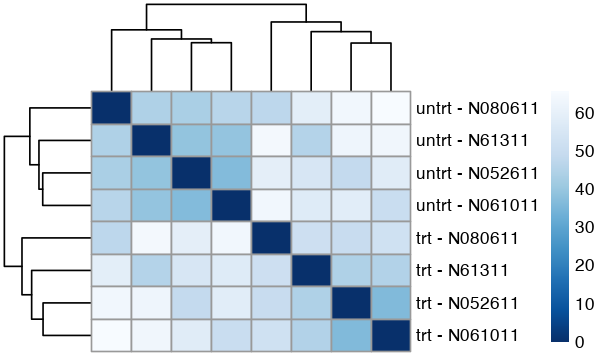

In [37]:
options(repr.plot.height=3, repr.plot.width=5)
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

**Heatmap of sample-to-sample distances using the rlog-transformed values.**

Note that we have changed the row names of the distance matrix to
contain treatment type and patient number instead of sample ID, so
that we have all this information in view when looking at the heatmap.

Another option for calculating sample distances is to use the
Poisson Distance, implemented in the
[PoiClaClu](https://cran.r-project.org/web/packages/PoiClaClu/index.html) CRAN package.
This measure of dissimilarity between counts
also takes the inherent variance
structure of counts into consideration when calculating the distances
between samples. The *PoissonDistance* function takes the original
count matrix (not normalized) with samples as rows instead of columns,
so we need to transpose the counts in `dds`.

In [56]:
library(PoiClaClu)
poisd <- PoissonDistance(t(counts(ddsESF)))

We plot the heatmap below.

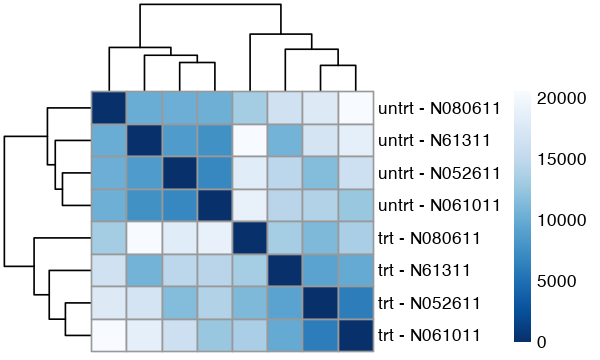

In [39]:
options(repr.plot.height=3, repr.plot.width=5)
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)

**Heatmap of sample-to-sample distances using the *Poisson Distance*.**

## PCA plot

Another way to visualize sample-to-sample distances is a
principal components analysis (PCA). In this ordination method, the
data points (here, the samples) are projected onto the 2D plane
such that they spread out in the two directions that explain most of
the differences (figure below). The x-axis is the direction that separates the data
points the most. The values of the samples in this direction are
written *PC1*. The y-axis is a direction (it must be *orthogonal* to
the first direction) that separates the data the second most. The
values of the samples in this direction are written *PC2*.
The percent of the total variance that is contained in the direction
is printed in the axis label. Note that these percentages do not add to
100%, because there are more dimensions that contain the remaining
variance (although each of these remaining dimensions will explain
less than the two that we see).

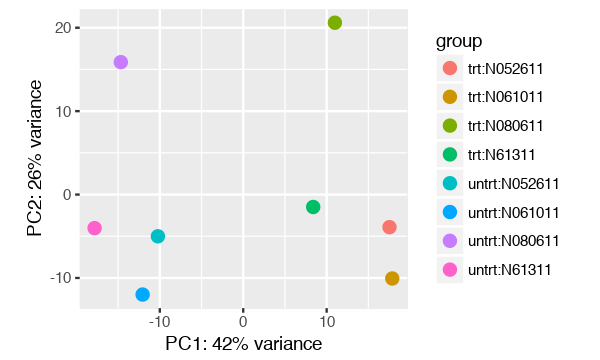

In [40]:
plotPCA(rld, intgroup = c("dex", "cell"))

**PCA plot using the rlog-transformed values.** Each unique combination of
treatment and cell line is given its own color.

Here, we have used the function *plotPCA* that comes with *DESeq2*.
The two terms specified by `intgroup` are the interesting groups for
labeling the samples; they tell the function to use them to choose
colors. We can also build the PCA plot from scratch using the
[ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html).
This is done by asking the *plotPCA* function
to return the data used for plotting rather than building the plot.
See the *ggplot2* [documentation](http://docs.ggplot2.org/current/)
for more details on using *ggplot*.

In [41]:
pcaData <- plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
pcaData
percentVar <- round(100 * attr(pcaData, "percentVar"))

,PC1,PC2,group,dex,cell,name
SRR1039508,-17.81773,-4.020835,untrt:N61311,untrt,N61311,SRR1039508
SRR1039509,8.38790,-1.490804,trt:N61311,trt,N61311,SRR1039509
SRR1039512,-10.22735,-5.004069,untrt:N052611,untrt,N052611,SRR1039512
SRR1039513,17.53277,-3.909890,trt:N052611,trt,N052611,SRR1039513
SRR1039516,-14.67169,15.873239,untrt:N080611,untrt,N080611,SRR1039516
SRR1039517,10.98782,20.598625,trt:N080611,trt,N080611,SRR1039517
SRR1039520,-12.06035,-11.985876,untrt:N061011,untrt,N061011,SRR1039520
SRR1039521,17.86863,-10.060389,trt:N061011,trt,N061011,SRR1039521


We can then use these data to build up a second plot in a figure below, specifying that the
color of the points should reflect dexamethasone treatment and the
shape should reflect the cell line.

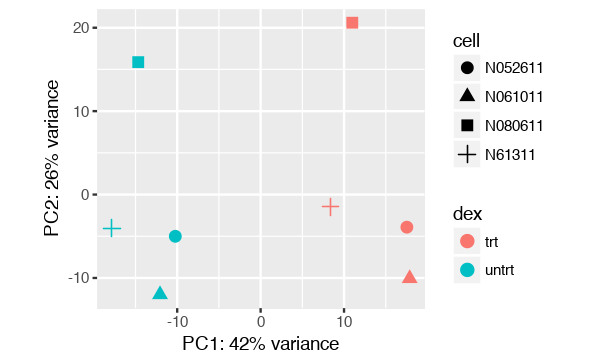

In [42]:
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()

**PCA plot using the rlog-transformed values with custom *ggplot2* code.**
Here we specify cell line (plotting symbol) and dexamethasone treatment (color).

From the PCA plot, we see that the differences between cells (the
different plotting shapes) are considerable, though not stronger than the differences due to
treatment with dexamethasone (red vs blue color). This shows why it will be important to
account for this in differential testing by using a paired design
("paired", because each dex treated sample is paired with one
untreated sample from the *same* cell line). We are already set up for
this design by assigning the formula `~ cell + dex` earlier.

## MDS plot

Another plot, very similar to the PCA plot, can be made using the 
*multidimensional scaling* (MDS) function in base R. This is useful when we
don't have a matrix of data, but only a matrix of distances. Here we
compute the MDS for the distances calculated from the *rlog*
transformed counts and plot these in a figure below.

**MDS plot using rlog-transformed values.**

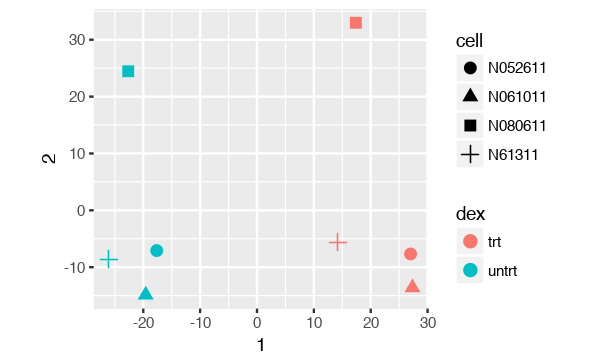

In [43]:
mds <- cbind(as.data.frame(colData(rld)), cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

In the figure below we show the same plot for the *PoissonDistance*.

**MDS plot using the *Poisson Distance*.**

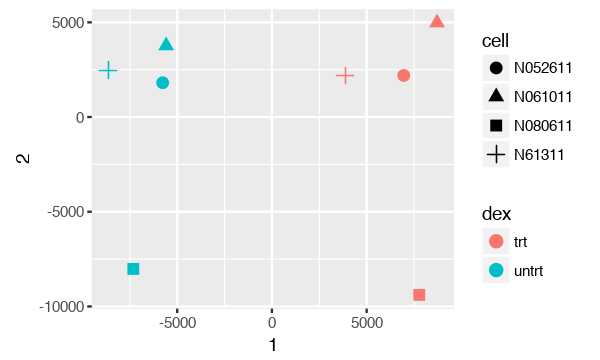

In [44]:
mdsPois <- cbind(as.data.frame(colData(ddsESF)),
   cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

# Appendix <a name="appendix"></a>

## Additional options for mapping transcripts to genes

**Option 2.** Bioconductor `TxDb.*` packages, which are available for a number of model species (search for "TxDb" at https://bioconductor.org/packages/3.6/data/annotation/). These are slightly less convenient for this purpose than the Ensembl packages. For example, there is a TxDb package Mus Musculus from UCSC build mm10 based on the knownGene Track:

In [45]:
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
keytypes(txdb)
k <- keys(txdb, "TXNAME")
columns(txdb)
tx4gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")

[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSSTART"  
 [6] "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"     "EXONNAME"  
[11] "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"     "TXCHROM"   
[16] "TXEND"      "TXID"       "TXNAME"     "TXSTART"    "TXSTRAND"  
[21] "TXTYPE"

'select()' returned 1:1 mapping between keys and columns


In [46]:
genes(txdb)
exonsBy(txdb)

GRanges object with 24044 ranges and 1 metadata column:
            seqnames                 ranges strand |     gene_id
               <Rle>              <IRanges>  <Rle> | <character>
  100009600     chr9 [ 21062393,  21075496]      - |   100009600
  100009609     chr7 [ 84940169,  84964009]      - |   100009609
  100009614    chr10 [ 77711446,  77712009]      + |   100009614
  100009664    chr11 [ 45808083,  45842878]      + |   100009664
     100012     chr4 [144157556, 144162651]      - |      100012
        ...      ...                    ...    ... .         ...
      99889     chr3 [ 84496093,  85887518]      - |       99889
      99890     chr3 [110246104, 110250999]      - |       99890
      99899     chr3 [151730923, 151749959]      - |       99899
      99929     chr3 [ 65528447,  65555518]      + |       99929
      99982     chr4 [136550533, 136602723]      - |       99982
  -------
  seqinfo: 66 sequences (1 circular) from mm10 genome

GRangesList object of length 63759:
$1 
GRanges object with 8 ranges and 3 metadata columns:
      seqnames             ranges strand |   exon_id   exon_name exon_rank
         <Rle>          <IRanges>  <Rle> | <integer> <character> <integer>
  [1]     chr1 [4807893, 4807982]      + |         1        <NA>         1
  [2]     chr1 [4808455, 4808486]      + |         2        <NA>         2
  [3]     chr1 [4828584, 4828649]      + |         3        <NA>         3
  [4]     chr1 [4830268, 4830315]      + |         4        <NA>         4
  [5]     chr1 [4832311, 4832381]      + |         5        <NA>         5
  [6]     chr1 [4837001, 4837074]      + |         6        <NA>         6
  [7]     chr1 [4839387, 4839488]      + |         7        <NA>         7
  [8]     chr1 [4840956, 4842827]      + |         9        <NA>         8

$2 
GRanges object with 9 ranges and 3 metadata columns:
      seqnames             ranges strand | exon_id exon_name exon_rank
  [1]     chr1 [4807893, 480

**Option 3.** Find a TxDb from AnnotationHub

This opens up more annotation files from different sources. First find and choose a TxDb database:

In [47]:
suppressPackageStartupMessages(library(AnnotationHub))
ah <- AnnotationHub()
query(ah, "TxDb")
txdb <- ah[["AH52245"]] #TxDb.Athaliana.BioMart.plantsmart22.sqlite

snapshotDate(): 2017-10-27


AnnotationHub with 45 records
# snapshotDate(): 2017-10-27 
# $dataprovider: UCSC
# $species: Rattus norvegicus, Gallus gallus, Homo sapiens, Caenorhabditis e...
# $rdataclass: TxDb
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH52245"]]' 

            title                                        
  AH52245 | TxDb.Athaliana.BioMart.plantsmart22.sqlite   
  AH52246 | TxDb.Athaliana.BioMart.plantsmart25.sqlite   
  AH52247 | TxDb.Athaliana.BioMart.plantsmart28.sqlite   
  AH52248 | TxDb.Btaurus.UCSC.bosTau8.refGene.sqlite     
  AH52249 | TxDb.Celegans.UCSC.ce11.refGene.sqlite       
  ...       ...                                          
  AH57988 | TxDb.Ggallus.UCSC.galGal5.refGene.sqlite     
  AH57989 | TxDb.Mmulatta.UCSC.rheMac3.refGene.sqlite    
  AH57990 | TxDb.Mmulatta.UCSC.rheMac8.refGene.sqlite    
  AH57991 | TxDb.

loading from cache '/Users/lwaldron//.AnnotationHub/58983'


Then use it to create the transcript-gene map:

In [48]:
keytypes(txdb)

[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

In [49]:
columns(txdb)

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSSTART"  
 [6] "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"     "EXONNAME"  
[11] "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"     "TXCHROM"   
[16] "TXEND"      "TXID"       "TXNAME"     "TXSTART"    "TXSTRAND"

In [50]:
k <- keys(txdb, "TXNAME")
tx5gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

'select()' returned 1:1 mapping between keys and columns


TXNAME,GENEID
AT1G01010.1,AT1G01010
AT1G01040.1,AT1G01040
AT1G01040.2,AT1G01040
AT1G01046.1,AT1G01046
AT1G01073.1,AT1G01073
AT1G01110.2,AT1G01110


** Option 4.** Import a GFF annotation file from somewhere else.

To convert the GFF file these to a TxDb database, use the `makeTxDbFromGFF()` function from the `GenomicFeatures` package:

In [51]:
library(GenomicFeatures)
gffFile <- system.file("extdata", "GFF3_files", "a.gff3", 
                       package="GenomicFeatures")
txdb <- makeTxDbFromGFF(file=gffFile,
            dataSource="partial gtf file for Tomatoes for testing",
            organism="Solanum lycopersicum")
keytypes(txdb)

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(type, phase):
"The "phase" metadata column contains non-NA values for features of type
  exon. This information was ignored."OK


[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

In [52]:
columns(txdb)

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSPHASE"  
 [6] "CDSSTART"   "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"    
[11] "EXONNAME"   "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"    
[16] "TXCHROM"    "TXEND"      "TXID"       "TXNAME"     "TXSTART"   
[21] "TXSTRAND"   "TXTYPE"

In [53]:
k <- keys(txdb, "TXNAME")
tx6gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

'select()' returned 1:1 mapping between keys and columns


TXNAME,GENEID
AT1G01010.1,AT1G01010
AT1G01040.1,AT1G01040
AT1G01040.2,AT1G01040
AT1G01046.1,AT1G01046
AT1G01073.1,AT1G01073
AT1G01110.2,AT1G01110


Note, the `GenomicFeatures` package enables you to make a TxDb from a variety of sources:

In [54]:
grep("makeTxDb", ls("package:GenomicFeatures"), val=TRUE)

[1] "makeTxDb"                   "makeTxDbFromBiomart"       
[3] "makeTxDbFromEnsembl"        "makeTxDbFromGFF"           
[5] "makeTxDbFromGRanges"        "makeTxDbFromUCSC"          
[7] "makeTxDbPackage"            "makeTxDbPackageFromBiomart"
[9] "makeTxDbPackageFromUCSC"